In [10]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os

### Loading Price Data

In [11]:
project_root = os.path.abspath(os.getcwd())

data_dir = os.path.join(project_root, '..', '..', 'data')

# Summer month

p_summer = pd.read_csv(os.path.join(data_dir, 'Spotmarket_August_2024.csv'),sep=';')


# Winter month

p_winter = pd.read_csv(os.path.join(data_dir, 'Spotmarket_December_2024.csv'),sep=';')


#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12


### Loading Fixed Appliances Data

In [12]:
#TV consumption data for summer month
tv_summer = pd.read_csv(os.path.join(data_dir, 'tv_consumption_august_2024_detailed.csv'), sep=',')

#TV consumption data for winter month
tv_winter = pd.read_csv(os.path.join(data_dir, 'tv_consumption_december_2024_detailed.csv'), sep=',')

#Lighting consumption data for summer month
lighting_summer = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_august_2024.csv'), sep=',')

#Lighting consumption data for winter month
lighting_winter = pd.read_csv(os.path.join(data_dir, 'lighting_consumption_december_2024.csv'), sep=',')

#Fridge consumption data for summer month
fridge_summer = pd.read_csv(os.path.join(data_dir, 'fridge_August_2024.csv'), sep=';')

#Fridge consumption data for winter month
fridge_winter = pd.read_csv(os.path.join(data_dir, 'fridge_December_2024.csv'), sep=';')

#Oven consumption data for summer month
oven_summer = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_August_2024.csv'),sep=';')

#Oven consumption data for winter month
oven_winter = pd.read_csv(os.path.join(data_dir, 'Oven_Energy_Consumption_December_2024.csv'),sep=';')

#Induction stove consumption data for summer month
induction_summer = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_August_2024.csv'),sep=';')

#Induction stove consumption data for winter month
induction_winter = pd.read_csv(os.path.join(data_dir, 'Induction_Stove_Energy_Consumption_December_2024.csv'),sep=';')


### Data formatting

In [13]:
#get column names
p_summer.columns = p_summer.columns.str.replace(' ', '_')
p_winter.columns = p_winter.columns.str.replace(' ', '_')
tv_summer.columns = tv_summer.columns.str.replace(' ', '_')
tv_winter.columns = tv_winter.columns.str.replace(' ', '_')
lighting_summer.columns = lighting_summer.columns.str.replace(' ', '_')
lighting_winter.columns = lighting_winter.columns.str.replace(' ', '_')
fridge_summer.columns = fridge_summer.columns.str.replace(' ', '_')
fridge_winter.columns = fridge_winter.columns.str.replace(' ', '_')
oven_summer.columns = oven_summer.columns.str.replace(' ', '_')
oven_winter.columns = oven_winter.columns.str.replace(' ', '_')
induction_summer.columns = induction_summer.columns.str.replace(' ', '_')
induction_winter.columns = induction_winter.columns.str.replace(' ','_')

# Convert the 'Date_(GMT+2)' column to datetime for easier manipulation
p_summer['Date_(GMT+2)'] = pd.to_datetime(p_summer['Date_(GMT+2)'])

p_winter['Date_(GMT+1)'] = pd.to_datetime(p_winter['Date_(GMT+1)'])


C:\Users\aless\AppData\Local\Temp\ipykernel_19080\2534668501.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p_summer['Date_(GMT+2)'] = pd.to_datetime(p_summer['Date_(GMT+2)'])
C:\Users\aless\AppData\Local\Temp\ipykernel_19080\2534668501.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p_winter['Date_(GMT+1)'] = pd.to_datetime(p_winter['Date_(GMT+1)'])


### Optimization

In [14]:
import pandas as pd
import gurobipy as gp
import itertools
from gurobipy import GRB

# Load data
price = p_summer["Price_(EUR/MWh)"].values
fridge = fridge_summer["Energy_kWh_1h"].values
stove = induction_summer["Energy_Consumption_kWh"].values
tv = tv_summer["tv_power_kWh"].values
lighting = lighting_summer["lighting_power_kWh"].values

Time_interval = len(price)

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"max_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")
    
#print(len(fridge))
#print(len(stove))
#print(len(tv))
#print(len(lighting))
#print(len(price))
#print(len(dishwasher_start))
#print(len(binary_dishwasher))
#print(len(start_times))



In [ ]:
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if dishwasher is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the washing machine has to run twice per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks-1):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
p_summer['Allowed_WM_summer'] = 0  # Initialize with 0
p_winter['Allowed_WM_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in p_summer.iterrows():
    hour = row['Date_(GMT+2)'].hour
    day_of_week = row['Date_(GMT+2)'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_summer.at[index, 'Allowed_WM_summer'] = 1
    else: 
        p_summer.at[index, 'Allowed_WM_summer'] = 0


for index, row in p_winter.iterrows():
    hour = row['Date_(GMT+1)'].hour
    day_of_week = row['Date_(GMT+1)'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        p_winter.at[index, 'Allowed_WM_winter'] = 1
    else: 
        p_winter.at[index, 'Allowed_WM_winter'] = 0
        
model.addConstrs((binary_wm[t] <= p_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
#model.addConstrs((binary_wm[t] <= p_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later



# Total power consumption including fixed and dishwasher
total_load = [fridge[t] + stove[t] + tv[t] + lighting[t] + power_dishwasher * binary_dishwasher[t] + power_wm * binary_wm[t] for t in range(0,720)]

# Objective: minimize total electricity cost
model.setObjective(gp.quicksum(price[t] * total_load[t] for t in range(720)), GRB.MINIMIZE)

# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Optimize a model with 7470 rows, 3717 columns and 28415 nonzeros
Model fingerprint: 0x24e5fa65
Variable types: 0 continuous, 3717 integer (3717 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 6165 rows and 2276 columns
Presolve time: 0.04s
Presolved: 1305 rows, 1441 columns, 11634 nonzeros
Variable types: 0 continuous, 1441 integer (1441 binary)
Found heuristic solution: objective 43961.688172

Root relaxation: objective 4.118927e+04, 260 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [ ]:
# Include electric vehicle charging
# EV properties

duration_ev = 2  # hours of operation


In [16]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {p_summer['Date_(GMT+2)'][t]}")
            wm_starts_list.append(p_summer['Date_(GMT+2)'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 41189.27
Washing machine starts at: 2024-03-08 16:00:00
Washing machine starts at: 2024-04-08 16:00:00
Washing machine starts at: 2024-06-08 10:00:00
Washing machine starts at: 2024-06-08 13:00:00
Washing machine starts at: 2024-09-08 13:00:00
Washing machine starts at: 2024-10-08 16:00:00
Washing machine starts at: 2024-11-08 16:00:00
Washing machine starts at: 2024-12-08 13:00:00
Washing machine starts at: 2024-08-15 16:00:00
Washing machine starts at: 2024-08-17 13:00:00
Washing machine starts at: 2024-08-18 13:00:00
Washing machine starts at: 2024-08-21 16:00:00
Washing machine schedule:
[Timestamp('2024-03-08 16:00:00'), Timestamp('2024-04-08 16:00:00'), Timestamp('2024-06-08 10:00:00'), Timestamp('2024-06-08 13:00:00'), Timestamp('2024-09-08 13:00:00'), Timestamp('2024-10-08 16:00:00'), Timestamp('2024-11-08 16:00:00'), Timestamp('2024-12-08 13:00:00'), Timestamp('2024-08-15 16:00:00'), Timestamp('2024-08-17 13:00:00'), Timestamp('2024-08-18 13:00:00'), Timestamp('202

In [17]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {p_summer['Date_(GMT+2)'][t]}")
        else:
            print(f"Washing Machine is OFF at: {p_summer['Date_(GMT+2)'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2024-01-08 00:00:00
Washing Machine is OFF at: 2024-01-08 01:00:00
Washing Machine is OFF at: 2024-01-08 02:00:00
Washing Machine is OFF at: 2024-01-08 03:00:00
Washing Machine is OFF at: 2024-01-08 04:00:00
Washing Machine is OFF at: 2024-01-08 05:00:00
Washing Machine is OFF at: 2024-01-08 06:00:00
Washing Machine is OFF at: 2024-01-08 07:00:00
Washing Machine is OFF at: 2024-01-08 08:00:00
Washing Machine is OFF at: 2024-01-08 09:00:00
Washing Machine is OFF at: 2024-01-08 10:00:00
Washing Machine is OFF at: 2024-01-08 11:00:00
Washing Machine is OFF at: 2024-01-08 12:00:00
Washing Machine is OFF at: 2024-01-08 13:00:00
Washing Machine is OFF at: 2024-01-08 14:00:00
Washing Machine is OFF at: 2024-01-08 15:00:00
Washing Machine is OFF at: 2024-01-08 16:00:00
Washing Machine is OFF at: 2024-01-08 17:00:00
Washing Machine is OFF at: 2024-01-08 18:00:00
Washing Machine is OFF at: 2024-01-08 19:00:00
Washing Machine is OFF at: 2024-01-08 20:00:00
Washing Machi

In [18]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {p_summer['Date_(GMT+2)'][t]}")
            dishwasher_starts_list.append(p_summer['Date_(GMT+2)'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 41189.27
Dishwasher starts at: 2024-01-08 13:00:00
Dishwasher starts at: 2024-02-08 07:00:00
Dishwasher starts at: 2024-03-08 13:00:00
Dishwasher starts at: 2024-04-08 13:00:00
Dishwasher starts at: 2024-05-08 12:00:00
Dishwasher starts at: 2024-06-08 12:00:00
Dishwasher starts at: 2024-07-08 13:00:00
Dishwasher starts at: 2024-08-08 13:00:00
Dishwasher starts at: 2024-09-08 12:00:00
Dishwasher starts at: 2024-10-08 12:00:00
Dishwasher starts at: 2024-11-08 12:00:00
Dishwasher starts at: 2024-12-08 12:00:00
Dishwasher starts at: 2024-08-13 12:00:00
Dishwasher starts at: 2024-08-14 21:00:00
Dishwasher starts at: 2024-08-15 13:00:00
Dishwasher starts at: 2024-08-16 12:00:00
Dishwasher starts at: 2024-08-17 13:00:00
Dishwasher starts at: 2024-08-18 13:00:00
Dishwasher starts at: 2024-08-19 12:00:00
Dishwasher starts at: 2024-08-20 12:00:00
Dishwasher starts at: 2024-08-21 13:00:00
Dishwasher starts at: 2024-08-22 12:00:00
Dishwasher starts at: 2024-08-23 12:00:00
Dishwasher st

In [19]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {p_summer['Date_(GMT+2)'][t]}")
        else:
            print(f"Dishwasher is OFF at: {p_summer['Date_(GMT+2)'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is OFF at: 2024-01-08 00:00:00
Dishwasher is OFF at: 2024-01-08 01:00:00
Dishwasher is OFF at: 2024-01-08 02:00:00
Dishwasher is OFF at: 2024-01-08 03:00:00
Dishwasher is OFF at: 2024-01-08 04:00:00
Dishwasher is OFF at: 2024-01-08 05:00:00
Dishwasher is OFF at: 2024-01-08 06:00:00
Dishwasher is OFF at: 2024-01-08 07:00:00
Dishwasher is OFF at: 2024-01-08 08:00:00
Dishwasher is OFF at: 2024-01-08 09:00:00
Dishwasher is OFF at: 2024-01-08 10:00:00
Dishwasher is OFF at: 2024-01-08 11:00:00
Dishwasher is OFF at: 2024-01-08 12:00:00
Dishwasher is ON at: 2024-01-08 13:00:00
Dishwasher is ON at: 2024-01-08 14:00:00
Dishwasher is ON at: 2024-01-08 15:00:00
Dishwasher is OFF at: 2024-01-08 16:00:00
Dishwasher is OFF at: 2024-01-08 17:00:00
Dishwasher is OFF at: 2024-01-08 18:00:00
Dishwasher is OFF at: 2024-01-08 19:00:00
Dishwasher is OFF at: 2024-01-08 20:00:00
Dishwasher is OFF at: 2024-01-08 21:00:00
Dishwasher is OFF at: 2024-01-08 22:00:00
Dishwasher is OFF at: 2024-01-08 23:0

In [20]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {p_summer['Date_(GMT+2)'][t]}")

Dishwasher start time: 2024-01-08 13:00:00
Dishwasher start time: 2024-02-08 07:00:00
Dishwasher start time: 2024-03-08 13:00:00
Dishwasher start time: 2024-04-08 13:00:00
Dishwasher start time: 2024-05-08 12:00:00
Dishwasher start time: 2024-06-08 12:00:00
Dishwasher start time: 2024-07-08 13:00:00
Dishwasher start time: 2024-08-08 13:00:00
Dishwasher start time: 2024-09-08 12:00:00
Dishwasher start time: 2024-10-08 12:00:00
Dishwasher start time: 2024-11-08 12:00:00
Dishwasher start time: 2024-12-08 12:00:00
Dishwasher start time: 2024-08-13 12:00:00
Dishwasher start time: 2024-08-14 21:00:00
Dishwasher start time: 2024-08-15 13:00:00
Dishwasher start time: 2024-08-16 12:00:00
Dishwasher start time: 2024-08-17 13:00:00
Dishwasher start time: 2024-08-18 13:00:00
Dishwasher start time: 2024-08-19 12:00:00
Dishwasher start time: 2024-08-20 12:00:00
Dishwasher start time: 2024-08-21 13:00:00
Dishwasher start time: 2024-08-22 12:00:00
Dishwasher start time: 2024-08-23 12:00:00
Dishwasher 

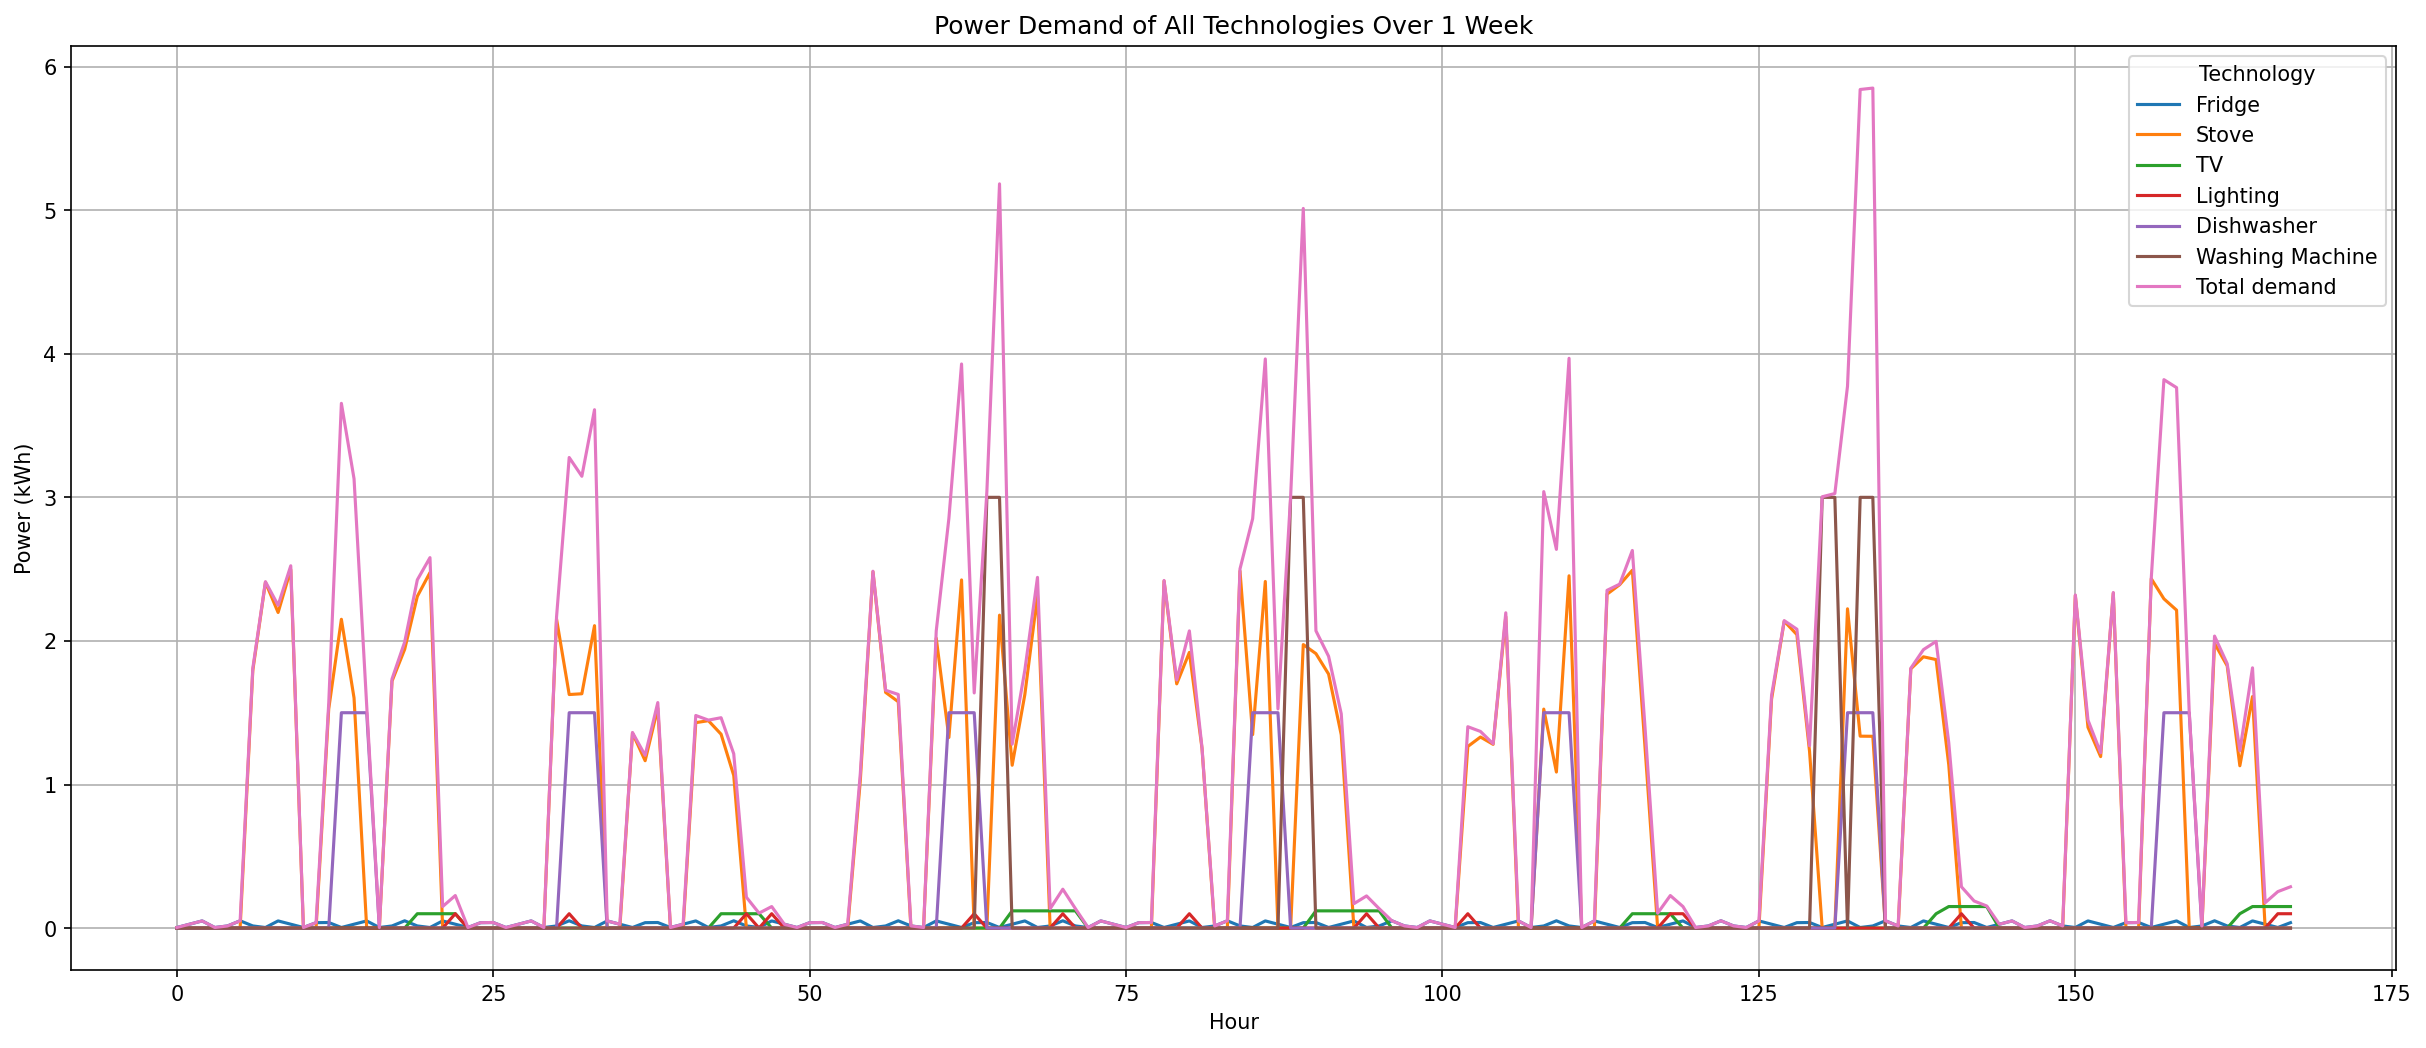

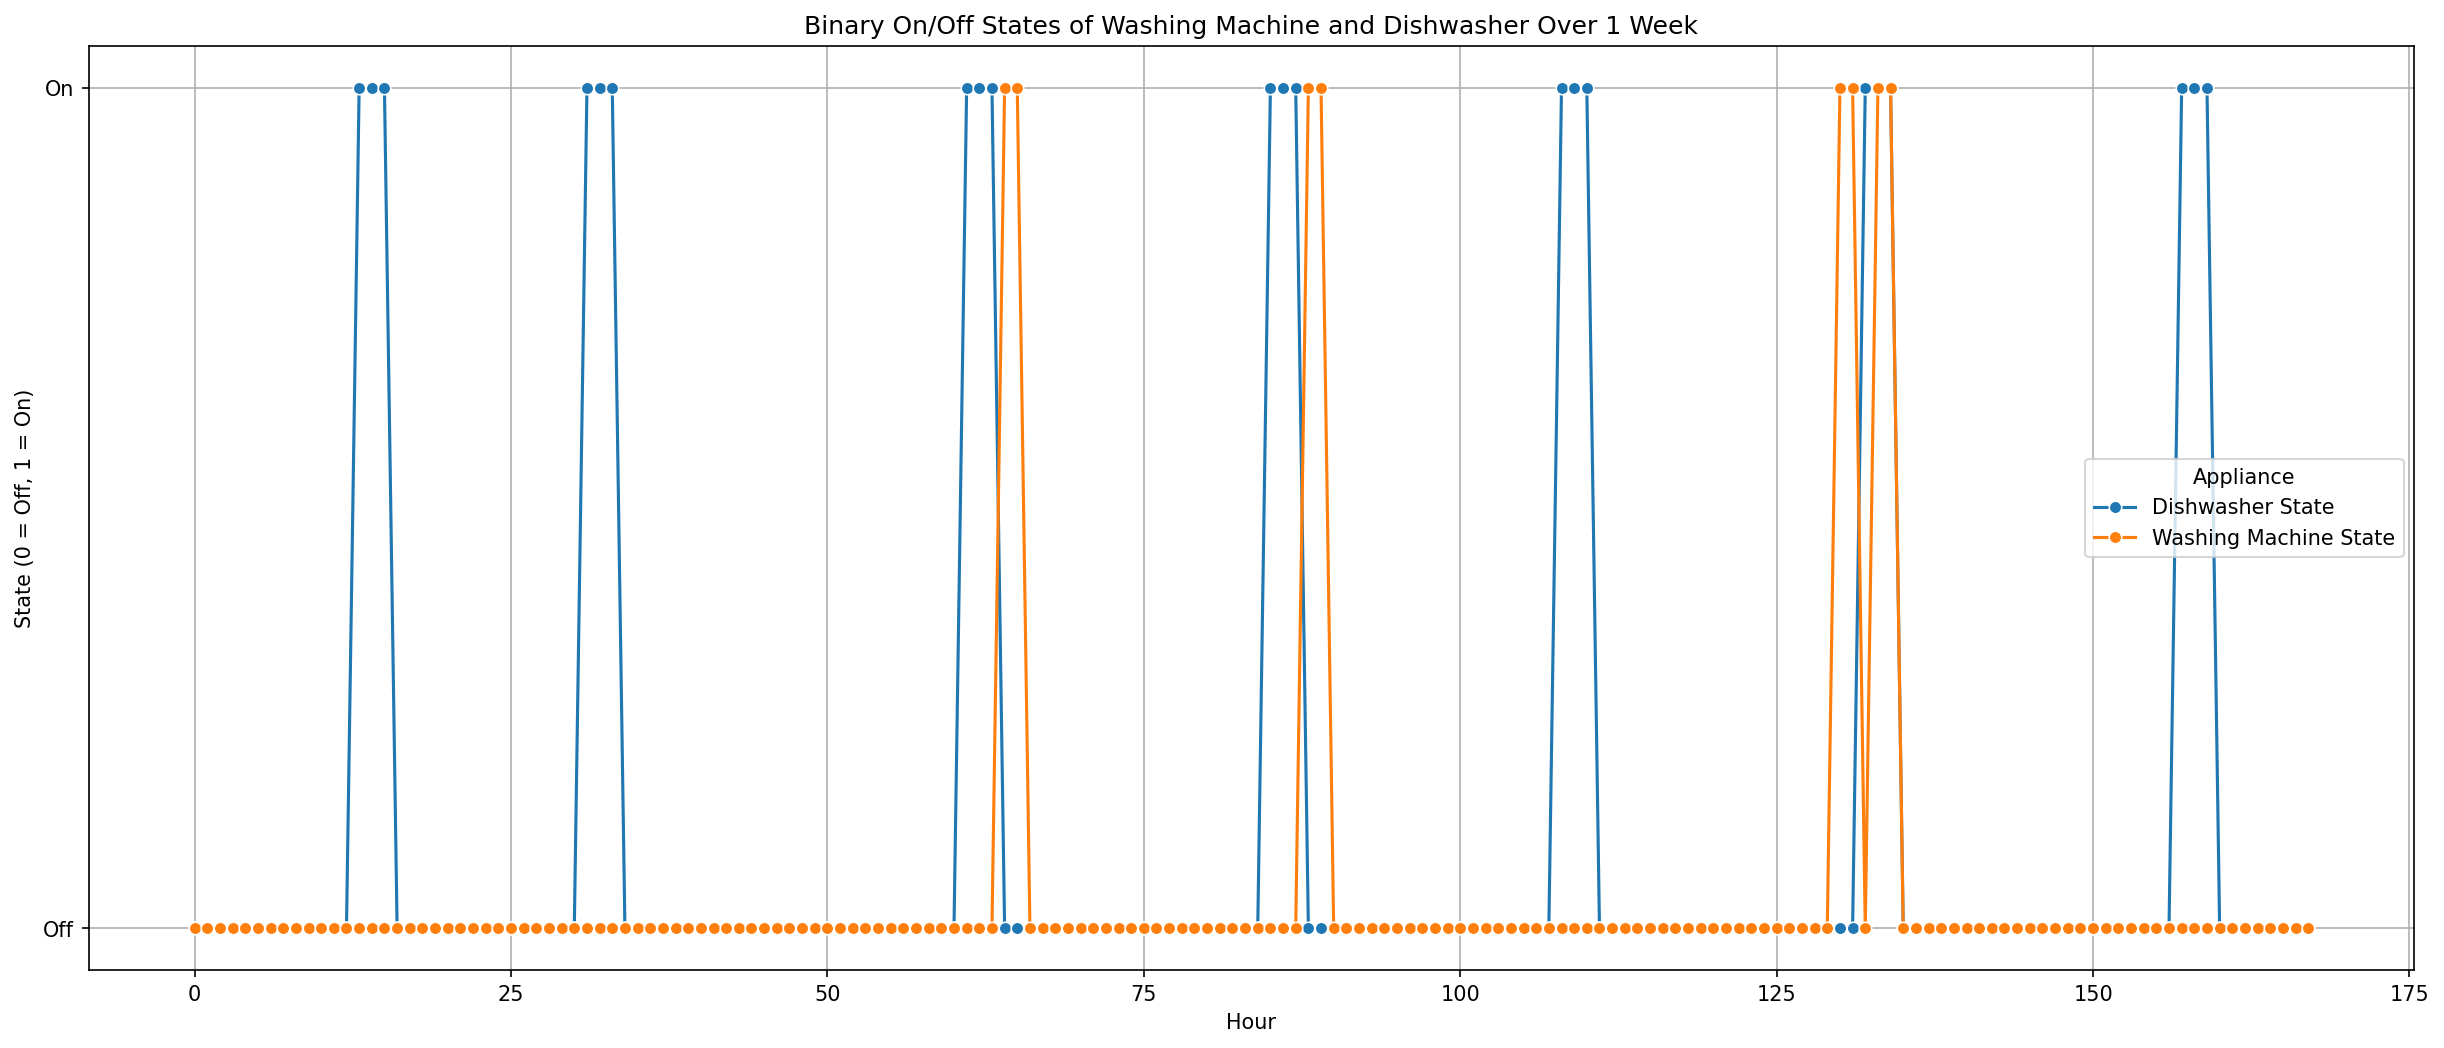

In [42]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range]
})

# Add the total power consumption
# Sum over all technologies for each row

cols_list = [col for col in data_power.columns if col != 'Hour']
data_power['Total demand'] = data_power[cols_list].sum(axis=1)



# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(20, 8),dpi=150)
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(20, 8),dpi=150)
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()


In [36]:
data_power

,Hour,Fridge,Stove,TV,Lighting,Dishwasher,Washing Machine,Total demand
0,0,0.003996,0.00000,0.00,0.0,-0.0,0.0,0.003996
1,1,0.026629,0.00000,0.00,0.0,-0.0,0.0,0.026629
2,2,0.049898,0.00000,0.00,0.0,-0.0,0.0,0.049898
3,3,0.003990,0.00000,0.00,0.0,-0.0,0.0,0.003990
4,4,0.014756,0.00000,0.00,0.0,-0.0,0.0,0.014756
...,...,...,...,...,...,...,...,...
163,163,0.003969,1.13048,0.10,0.0,-0.0,0.0,1.234449
164,164,0.049941,1.61268,0.15,0.0,-0.0,0.0,1.812621
165,165,0.026604,0.00000,0.15,0.0,-0.0,0.0,0.176604
166,166,0.003993,0.00000,0.15,0.1,-0.0,0.0,0.253993
